# Introduction à l'apprentissage par renforcement
# TP 1 - les manchots multi-bras

1/4 de la note finale est liée à la mise en forme : 

* pensez à nettoyer les outputs inutiles (installation, messages de débuggage, ...)
* soignez vos figures : les axes sont-ils faciles à comprendre ? L'échelle est adaptée ? 
* commentez vos résultats : vous attendiez-vous à les avoir ? Est-ce étonnant ? Faites le lien avec la théorie.

Ce TP reprend l'exemple d'un médecin et de ses vaccins. Vous allez comparer plusieurs stratégies et trouver celle optimale.
Un TP se fait seul ou en binôme. Aucun groupe de plus de 2 personnes. 

Vous allez rendre le TP depuis un lien GitHub avec ce notebook mais une version du rapport exportée en PDF & HTML. 

In [ ]:
# ! pip install matplotlib tqdm numpy ipympl opencv-python
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager
# !jupyter labextension install jupyter-matplotlib

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

import typing as t
import math
import torch
import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2
from IPython.display import display, clear_output

torch.random.manual_seed(0)

K = 5 # num arms

# Présentation du problème

In [4]:
class ArmBernoulli:
    def __init__(self, p: float):
        """
        Vaccine treatment following a Bernoulli law (mean is p and variance is p(1-p)
        Args:
             p (float): mean parameter
             
        >>> torch.random.manual_seed(random_state)        
        >>> arm = ArmBernoulli(0.5)
        >>> arm.sample(5)
        tensor([ True, False,  True,  True,  True])
        """
        self.immunity_rate = p

    def sample(self, n: int = 1):
        return torch.rand(n) < self.immunity_rate
    
    def __repr__(self):
        return f'<ArmBernoulli p={self.immunity_rate}' 

def generate_arms(num_arms: int):
    means = torch.rand(num_arms)
    MAB = [ArmBernoulli(m) for m in means]
    assert MAB[0].immunity_rate == means[0]
    assert (MAB[0].sample(10) <= 1).all() and (MAB[0].sample(10) >= 0).all() 
    return MAB

MAB = generate_arms(K)

Ce TP reprend l'exemple du médecin présenté en cours.


**Q1. Créez une fonction pour trouver $\mu^*$ à partir d'un `MAB`. Comment est définie la récompense $R_k$ ? Que représente concrètement le regret dans le contexte de ce TP ?**

In [5]:
def best_vaccine_in_mab(mab):
    # return the index of the best vaccine in the MAB
    return np.array([vaccine.immunity_rate for vaccine in mab]).argmax()

print(f"Best vaccine in MAB: {best_vaccine_in_mab(MAB)}")
for i, arm in enumerate(MAB):
        print(f"Vaccine {i} has immunity rate {arm.immunity_rate.item():.2f}")

Best vaccine in MAB: 1
Vaccine 0 has immunity rate 0.50
Vaccine 1 has immunity rate 0.77
Vaccine 2 has immunity rate 0.09
Vaccine 3 has immunity rate 0.13
Vaccine 4 has immunity rate 0.31


La récompense $R_k$ est définie selon la loi de Bernoulli, donc 1 (p) si c'est une réussite et 0 (1-p) si échec.

Le regret représente la différence entre le fonctionnement théorique du vaccin (phase de d'exploration) et l'exploitation réelle de la chance d'immunisation.

**Note importante :** pour la suite, les résultats seront généralement réalisés avec 100 initialisations différentes du MAB (tous les MAB ont 5 vaccins mais des taux d'immunistation différent) pour réduire le bruit de simulation. Concrètement, on exécutera au moins 100x `generate_arms`.

# I. Cas classique des bandits manchots 

## I.a. Solution Gloutonne

Le médecin fonctionne sur deux phases :

1. **Exploration :** Le médecin calcule le taux d'immunisation empirique sur les N premiers patients en administrant le même nombre de fois chaque vaccin :

$$\hat{\mu_i}[0\rightarrow N] = \frac{1}{T_i} \sum_{k=0}^{N-1} \chi_{v_k,i}R_k,$$

avec $T_i = \sum_{k=0}^{N-1} \chi_{v_k,i}$.


2. **Exploitation :** Le vaccin $v_i = \arg\max_j \hat{\mu_j}[0\rightarrow N]$ est utilisé pour les M patients suivants.

**Q2. Implémentez cette solution avec N = 50 et M = 500 et testez-la avec 100 MAB. On souhaite savoir si vous trouvez le vaccin optimal à l'issue d'une phase d'exploration. Quelle est l'espérance empirique de cette variable ? Et son écart-type ? Calculez de même l'espérance et l'écart-type du regret sur vos 100 simulations.**

Pour rappel, le regret est défini par :

$$r_n = n\mu^* - \sum_{k=0}^{n-1} R_k$$

**Attention :** $n$ est le nombre total de patients, donc ici $N + M$.

In [7]:
Mab_list = [generate_arms(5) for _ in range(100)]
N = 50
M = 500

In [9]:
def exploration(n, mab):
    R = np.zeros(K)
    for i, arm in enumerate(mab):
        R[i] = arm.sample(n // K).sum()
    return R

def getBestVaccin(R, hist):
    Ri = np.zeros(K)
    for i in range(K):
        Ri[i] = R[i] / hist[i]
    return Ri.argmax()

def exploitation(n,m, mab_list):
    rates = []
    regrets = []
    for mab in mab_list:
        # Phase d'exploration
        R = exploration(n, mab)
        # exploitation
        hist = [n // K] * K        
        bestVac= getBestVaccin(R, hist)
        Mab_res = mab[bestVac].sample(m).sum()
        R[bestVac] += Mab_res
        hist[bestVac] += m
        ### exploration success rate
        list_immunity_rates = [i.immunity_rate for i in mab]
        best_vac_from_immunity_rates = best_vaccine_in_mab(mab)
        success = (bestVac == best_vac_from_immunity_rates)
        ### regret
        regret = (n + m) * max(list_immunity_rates) - R.sum()

        regrets.append(regret)
        rates.append(success)

    return regrets, rates

regrets, rates = exploitation(N, M, Mab_list)

mean_rates = np.mean(rates)
std_rates = np.std(rates)
mean_regret = np.mean(regrets)
std_regret = np.std(regrets)

print(f"Espérance: {mean_rates}")
print(f"Écart-type: {std_rates}")
print(f"Espérance du regret: {mean_regret}")
print(f"Écart-type du regret: {std_regret}")

Espérance: 0.77
Écart-type: 0.4208325082500163
Espérance du regret: 27.029726028442383
Écart-type du regret: 26.400968551635742


**Q3. On étudie maintenant l'influence de la taille du training set $N$. On considère que N+M est une constante, puis on fait varier N entre K et M. Calculez le regret pour ces différentes tailles du training set  différents MAB et representez le regret moyen, le regret min et max (vous devriez trouver une courbe en U ou en V pour le regret moyen). Quelle est la taille optimale du training set ?**

min: 30.03, k: 35
max: 172.65, k: 540
mean: 93.09


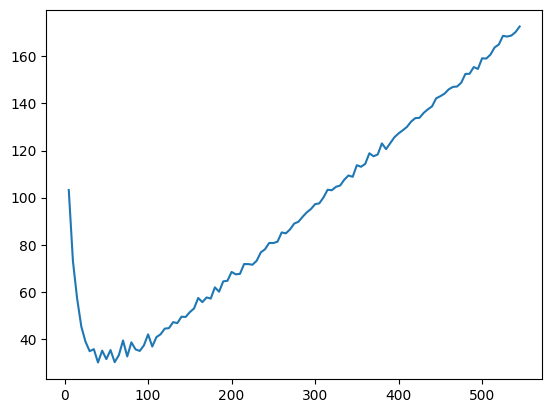

In [17]:
def exploitation(n,m, mab_list):
    rates = []
    regrets = []
    for mab in mab_list:
        # Phase d'exploration
        R = exploration(n, mab)
        # exploitation
        hist = [n // K] * K        
        bestVac= getBestVaccin(R, hist)
        Mab_res = mab[bestVac].sample(m).sum()
        R[bestVac] += Mab_res
        hist[bestVac] += m
        ### regret
        regret = (n + m) * max([i.immunity_rate for i in mab]) - R.sum()
        regrets.append(regret)

    return regrets

m = N + M
Mab_list = [generate_arms(K) for _ in range(100)]
Mab_list_regrets = []
for n in range(K,m, K):
    regrets = exploitation(n, m - n, Mab_list)
    Mab_list_regrets.append(np.mean(regrets))

print(f'min: {min(Mab_list_regrets):.2f}, k: {Mab_list_regrets.index(min(Mab_list_regrets)) * 5}')
print(f'max: {max(Mab_list_regrets):.2f}, k: {Mab_list_regrets.index(max(Mab_list_regrets)) * 5}')
print(f'mean: {np.mean(Mab_list_regrets):.2f}') 

plt.plot(range(K,m, K), Mab_list_regrets)
plt.show()


*[Ajoutez votre commentaire ici]*

**Q4. On propose d'améliorer l'algorithme précédant en mettant à jour les taux d'immunisation empiriques $\hat{\mu}_i$ pendant la phase d'exploitation (algorithme *greedy*). Concrètement, à chaque nouvel patient, on lui administre le meilleur vaccin selon les stats. Notez vous une amélioration du regret ? Proposez un exemple où les taux d'immunisation du MAB ne changent rien.** 

In [18]:
def exploitation(n,m, mab_list):
    regrets = []
    for mab in mab_list:
        # Phase d'exploration
        R = exploration(n, mab)
        # exploitation
        list_immunity_rate = [i.immunity_rate.item() for i in mab]
        bestVacGt = list_immunity_rate.index(max(list_immunity_rate))
        hist = [n // K] * K        

        ## regret
        regret = n * list_immunity_rate[bestVacGt] - R.sum()
        regrets.append(regret)

        
        regret_list = []
        total_rewards = R.sum()

        for i in range(1, m + 1):  
            bestVac = getBestVaccin(R, hist)
            Mab_res = mab[bestVac].sample()
            hist[bestVac] += 1
            R[bestVac] += Mab_res
            total_rewards += Mab_res
            # Mise à jour du regret à chaque étape
            regret = (n + i) * list_immunity_rate[bestVacGt] - total_rewards
            regret_list.append(regret)

    return regret_list

Mab_list = [generate_arms(K) for _ in range(100)]
regrets = exploitation(N, M, Mab_list)

print(f'min: {min(regrets).item():.2f}, k: {regrets.index(min(regrets))}')
print(f'max: {max(regrets).item():.2f}, k: {regrets.index(max(regrets))}')
print(f'mean: {np.mean(regrets):.2f}')

min: 11.29, k: 319
max: 25.42, k: 6
mean: 16.91


*[Ajoutez votre commentaire ici]*

**Q5. Nouvelle amélioration : à chaque nouveau patient, on choisit si on lui administre le meilleur vaccin avec une probabilité $\epsilon$ ou un vaccin aléatoire ($p=1-\epsilon$). Vérifiez si vous obtenez un meilleur résultat avec N = 0 ou N > 0. À votre avis, à quoi sert $\epsilon$ ?** 

In [19]:
def exploitation(n,m, mab_list, epsilon):
    regrets = []
    for mab in mab_list:
        # Phase d'exploration
        R = exploration(n, mab)
        # exploitation
        list_immunity_rate = [i.immunity_rate.item() for i in mab]
        bestVacGt = list_immunity_rate.index(max(list_immunity_rate))
        hist = [n // K] * K        

        ## regret
        regret = n * list_immunity_rate[bestVacGt] - R.sum()
        regrets.append(regret)

        
        regret_list = []
        total_rewards = R.sum()

        for i in range(1, m + 1):  
            if (np.random.rand() <= epsilon):
                bestVac = getBestVaccin(R, hist)
            else:
                bestVac = np.random.randint(K)
            Mab_res = mab[bestVac].sample()
            hist[bestVac] += 1
            R[bestVac] += Mab_res
            total_rewards += Mab_res
            # Mise à jour du regret à chaque étape
            regret = (n + i) * list_immunity_rate[bestVacGt] - total_rewards
            regret_list.append(regret)

    return regret_list

Mab_list = [generate_arms(K) for _ in range(100)]
Mab_list_regrets = []

regrets_N = exploitation(N, M, Mab_list, 0.7)
regrets_0 = exploitation(0, M + N, Mab_list, 0.7)

print(f'N = 0, regret = {np.mean(regrets_0):.2f}')
print(f'N > 0, regret = {np.mean(regrets_N):.2f}')

C:\Users\gatig\AppData\Local\Temp\ipykernel_13376\1431928959.py:10: RuntimeWarning: invalid value encountered in scalar divide
  Ri[i] = R[i] / hist[i]


N = 0, regret = 8.48
N > 0, regret = 25.12


*[Ajoutez votre commentaire ici]*

## I.b. Borne inférieure de Lai & Robbins [Lai et Robbins, 1985]

Lai et Robbins [Lai et Robbins, 1985] considère une classe d'algorithmes $\pi$ pour résoudre ce type de problèmes.

Ils ont trouvé une borne inférieure sur les récompenses cumulées en valeur asymptotique :

$$\lim_{n\rightarrow \infty} \inf_{\pi} \frac{\sum_{k=0}^{n-1} R_k}{\log n} \geq \sum_{i~\text{tel que}~\mu_i \lt \mu^*} \frac{\mu^∗−\mu_i}{\text{KL}(\mu_i, \mu^*)}  :=C(\mu)$$
 
 avec $\text{KL}(x, y) = x \log(x/y) + (1 − x) \log((1 − x)/(1 − y))$ (distance de Kullback-Leibler) et  $\sum_{k=0}^{n-1} R_k$ la récompense obtenue sur $n$ patients.
 
 
**Q6. Justifiez pourquoi on peut en déduire que le regret d'un algorithme raisonnable sera au pire logarithmique.**

*[Ajoutez votre commentaire ici]*

**Q7. Tracez le regret issu de la borne de Lai & Robbins et comparez le au regret obtenu avec l'algorithme glouton.**

*[Ajoutez votre commentaire ici]*

## I.c. Upper Confidence Bounds

Cet algorithme améliore la version précédente en ajoutant un biais lié à la fréquentation de chaque vaccin :

$$\bar{\mu}_i = \hat{\mu}_i + \sqrt{\frac{C\log{n}}{T_i}}$$,

avec $C=2$.


**Q8. Implémentez la modification de cet algorithme. Observez un intérêt à conserver $N > 0$ ? Et $\epsilon < 1$ ? Expliquez pourquoi.**

Dans la suite, on prendra $N = 0$ et $\epsilon = 1$.

*[Ajoutez votre commentaire ici]*

**Q9. Tracez sous la forme d'une animation l'évolution du regret et l'évolution des taux d'immunisation empirique. Dans la figure de gauche, vous representerez $\bar{\mu}_i$ et $\hat{\mu}_i$.**

*[Ajoutez votre commentaire ici]*

**Q10. Reprenez la question Q5 avec cette algorithme. Concluez sur l'utilité (ou l'inutilité) de la phase d'exploration. Comparez les performances d'UCB avec celles de l'algorithme glouton.**

*[Ajoutez votre commentaire ici]*

**Q11. Testez différentes valeurs pour $C$ et trouvez sa valeur optimale expérimentalement.**

*[Ajoutez votre commentaire ici]*

# Echantillonnage de Thomson

Cet algorithme propose de modéliser la variable aléatoire de chaque vaccin avec une loi $\beta$ dont les paramètres $a$ et $b$ correspondent au nombre de patients que le vaccin a immunisés (resp. non immunisés).

Pour chaque patient, on tire un valeur aléatoire pour la loi $\beta$ décrivant chaque vaccin, puis on choisit le vaccin avec la plus grande valeur tirée. 

**Q12. Implémentez cet algorithme. Conservez les deux phases exploration/exploitation décrites ci-dessus. En prenant les valeurs de $N$ et $M$ trouvées à la question Q5, quel regret obtenez-vous ? Faites l'expérience avec au moins 10 MAB différents (tous ayant 5 vaccins) afin de calculer la moyenne et l'écart-type du regret.**

*[Ajoutez votre commentaire ici]*

**Q13. Reprenez la question Q4, mais cette fois-ci, vous representerez le taux d'immunisation empirique avec un [graphique en violon](https://en.wikipedia.org/wiki/Violin_plot) qui représente la loi beta associée à chaque vaccin.**

*[Ajoutez votre commentaire ici]*

**Q14. Représentez son regret pour différentes tailles du training set (comme dans la Q5). Comparez le regret avec les autres algorithmes.**

*[Ajoutez votre commentaire ici]*

# Conclusion

**Q15. Calculez le regret des algorithmes glouton, UCB & Thomson lorsqu'il y a un grand nombre de vaccins disponibles (K=100) (on prendra N=100). Faites le lien avec la [malédiction de la dimension](https://fr.wikipedia.org/wiki/Fl%C3%A9au_de_la_dimension).**

*[Ajoutez votre commentaire ici]*